<a href="https://colab.research.google.com/github/bulikatan/MNB/blob/main/Stacked_BiLSTM_Model_Sentiment_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Preliminaries**

# **# Set Up**

Almost all NLP task including Sentiment Analysis which is used to understand public  reception of the product use language models. The general setup is that we have a language and we build a model for the language. Language models have been train to host the task like language translation, question answering and among others.

For sentiment analysis task we have used it to determine whether comments are pos, neg, or neut and how opinionated they are.SA is a NLP technique of identifying trends and inclination of the masses through the representative information available

In [1]:
#mount drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os

os.chdir("/content/drive/MyDrive/Colab Notebooks/data")
cwd = os.getcwd()  # Get the current working directory (cwd)
files = os.listdir(cwd)  # Get all the files in that directory
#print("Files in %r: %s" % (cwd, files))

In [3]:
#libraries and functions

import numpy as np
import re
import seaborn as sns

import gensim
from gensim.models import word2vec
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import sent_tokenize,word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

import pandas as pd

dataSet = pd.read_csv('/content/drive/MyDrive/Dataset/BINARYDATASET.CSV')
df =pd.DataFrame(dataSet)

#EDA (Structure and Quantity)
#f.isnull().sum() # Determine whether there are any missing values in our dataframe
#df.isna().sum()
#df=df.dropna()    # drop empty rows, impute null values

#converting POLARITY column into numeric target 
#df['POLARITY']=df.POLARITY.map({'POSITIVE':1,'NEGATIVE':0})
df['POLARITY'].replace({'POSITIVE':1,'NEGATIVE':0},inplace=True)

**`Step 1. Text Prepocessing**`
0. Convert all characters to lowercase.
1. Remove digits       
2. Extend Contractions
3. Remove Punctuations       
4. Remove ASCII characters
5. Change Morphemes (all e's to i's and o's to u's)
6. Remove Single Character String

# **Data Preprocessing**

In [4]:
import string
def convert_tolowercase(text):
    for word in range(len(text)):
        text[word] = text[word].lower()       
    return text

In [5]:
#Remove the word with a number
def remove_digits(text):
    new_words = []
    for word in text:
        new_word=re.sub(r"\d+", "", word)
        if new_word != '':
           new_words.append(new_word)
    return new_words

In [6]:
import re
import nltk

nltk.download('punkt')
import string
from nltk.tokenize import word_tokenize
#from nltk.corpus import stopwords
#from nltk.stem.porter import PorterStemmer

def clean_text(lines):
    all_reviews = list()
  #  lines = df["REVIEWS"].tolist()
    for text in lines:
        text = text.lower()
        
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        text = emoji.sub(r'', text)
        
        text = re.sub(r"i'm", "i am", text)
        text = re.sub(r"he's", "he is", text)
        text = re.sub(r"she's", "she is", text)
        text = re.sub(r"that's", "that is", text)        
        text = re.sub(r"what's", "what is", text)
        text = re.sub(r"where's", "where is", text) 
        text = re.sub(r"\'ll", " will", text)  
        text = re.sub(r"\'ve", " have", text)  
        text = re.sub(r"\'re", " are", text)
        text = re.sub(r"\'d", " would", text)
        text = re.sub(r"\'ve", " have", text)
        text = re.sub(r"won't", "will not", text)
        text = re.sub(r"don't", "do not", text)
        text = re.sub(r"did't", "did not", text)
        text = re.sub(r"can't", "can not", text)
        text = re.sub(r"it's", "it is", text)
        text = re.sub(r"couldn't", "could not", text)
        text = re.sub(r"have't", "have not", text)
        
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
        tokens = word_tokenize(text)
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        words = [word for word in stripped if word.isalpha()]
#         stop_words = set(stopwords.words("english"))
#         stop_words.discard("not")
#         words = [w for w in words if not w in stop_words]
        words = ' '.join(words)
        all_reviews.append(words)
    return all_reviews

#all_reviews = clean_text(data)
#all_reviews[0:20]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [7]:
contractions={ 
    "kuwarto":"kwarto","kuwarta":"kwarta",
    "abogasiya":"abogasya",
    "adunay":"aduna may",
   "agi'g":"agi ug", "agi'g":"agi ug",
    "angay'ng":"angay nga",
    "asa'y":"asa may",
    "ato'ng":"ato nga",
    "atoang":"atoa nga",
    "aduna'y":"aduna may","adunaha'ng":"adunahan nga",
    "ako'y":"ako may","apektado'ng":"apektado nga","adlaw'ng":"adlaw nga",
    "bahala'g":"bahala ug","ba'y":"ba diay","bali'g":"bali ug",
    "banay'ng":" banay nga",
    "bisa'g":"bisan ug",
    "diay'g":"diay ug","dako'ng":"dako nga","duna'y":"duna may","dayo'g":"dayon ug",
    "dako'ng":"dako nga",
    "du't":"duot",
    "gagmay'ng":"gagmay nga","ginagmay'ng":"ginagmay nga",
    "gamay'ng":"gamay nga","gamayng":"gamay nga",
    "gyu'y":"gyud may","gayu'y":"gyud may","gyuy":"gayud may","g'yuy":"gyud may",
    "g'yud":"gayud", # 
    "iro'ng":"iro nga","kanato'ng":"kanato nga","inadlaw'ng":"inadlaw nga",
    "gihimong":"gihimo nga", "nahimong":"nahimo nga","nakahimong":"nakahimo nga",
    "iyang":"iya nga",
    "kini'g":"kini ug",
    "kita'g":"kita ug",
    "la'g":"lang ug","langyaw'ng":"langyaw nga","hinuo'y":"hinuon may","mo'g":"mo ug",
    "maghimo'g":"maghimo ug",  
    "mangita'g":"mangita ug",
    "mura'g":"mura ug","magkunsumo'g":"magkunsumo ug","makapaagni'g":"makapaagni ug",
    "mangita'g":"mangita ug",
    "mipasaka'g":"mipasaka ug",
    "pagpangita'g":"pagpangita ug",
    "mi'g":"kami ug","mo'y":"mo may","mao'y":"mao may","magmaneho'g":"magmaneho ug",
    "magsigeg":"magsige ug",
    "milabay'ng":"milabay'ng","maayo'ng":"maayo nga","inantigo'ng":"inantigo nga",
    "nahibu'ng":"nahibulong",
    "nahuptan'g":"nahuptan nga",
    "madutla'g":"madutlan ug",
    "mura'g":"mura ug",
    "nakalabay'ng":"nakalabay nga",
    "nila'g":"nila ug",
    "naghimo'g":"naghimo ug","nahimong":"nahimo nga","naninda'g":"naninda ug",
    "nganong":"ngano nga","nagbato'g":"nagbaton ug","kahimoa'g":"kahimoan ug",
    "kagagmayg":"kagagmay ug",
    "ko'y":"ko may",
    "ko'g":"ko ug",
    "kagahig":"kagahi ug","kanato'ng":"kanato ang",
    "kinig":"kini ug",
    "kita'g":"kita ug","kaayo'y":"kaayo may","kaugalingo'ng":"kaugalingon nga","kaha'y":"kaha may","kanunay'ng":"kanunay nga",
    "na'y":"naa may","nagbato'g":"nagbanton ug","nga'n":"ngalan",
    "nangita'g":"nangita ug",
    "naa'y":"naa may","ni'ng":"niini nga","niini'ng":"niini nga","na'g":"na ug","naasoy'ng":"naasoy nga",
    "nagpatugatuga'g":"nagpatugatuga ug","na'g":"na ug",
    "ni'g":"kini ug","negatibo'g":"negatibo ug","gagmay'ng":"gagmay nga",
    "ordinaryo'ng":"ordinaryo nga",
    "panumba'y":"panung sa balay",
    "pu'y":"pud diay","paghimo'g":"paghimo ug","pagmaneho'g":"pagmaneho ug","pila'y":"pila may",
    "pa'y":"pa may","patay'ng":"patay nga","pa'ng":"pa nga","piniliay'ng":"piniliay nga",
    "paghimo'g":"paghimo ug","pagkao'g":"pagkaon ug",
    "pordoy'ng":"pordoy nga","pagsige'g":"pagsige ug","pagpamaligya'g":"pagpamaligya ug",
    "ra'y":"ra may","ra'g":"ra ug","sila'g":"sila ug",
    "selyula'ng":"selyula nga","sa'y":"sab may",
    "sila'y":"sila may","siya'y":"siya may",
    "tawhano'ng":"tawhanon nga","tawhanong":"tawhanon nga",
    "ta'y":"ta may","ta's":"ta sa",
    "uban'g":"uban nga","usa'y":"usa may","unya'g":"unyag ug",
    "unsa'y":"unsa may","unta'g":"unta ug","usa'g-usa":"usa ug usa",
    "wala'y":"wala may", "wa'y":"wala may",    
    # the danger of the shortened words is there presence as a substring in the textual unit when replaced: 
    #"wa":"wala",
    #"way":"wala may" "mi'g":"mi ug","mi":"kami", "kog":"ko ug", ,"koy":"ko may","kitag":"kita ug"
    #"ko":"ako","murag":"mura ug", "pay":"pa may","naay":"naa may","nig":"ni ug","ni":"kini","sab":"usab",.
}

def cont_to_exp(text):
    new_words=[]
    for word in text:
        if type(word) is str: 
    #To do: The word must be a distinct string NOT as substring to avoid repetition Ex. wa = wala <> kawawa should be kawawa not kawalawala
      #pattern = re.compile(r'\b[\w]\b')
          for key in contractions:
            value =contractions[key]
            word = word.replace(key,value)
        new_words.append(word)
            
    return new_words


In [8]:
import unicodedata
def remove_non_ascii(text):
#"""Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in text:
        new_word = unicodedata.normalize('NFKD',word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [9]:
import re
import string
#nltk.download ("punkt")

def remove_punctuations(words):
#Remove punctuations make sure all are removed
    new_words = []
    for word in words:    
        
       # new_word = re.sub(r"[-()\"#/@;:<>{}=~|.?,&$]!", "", word)
        new_word = re.sub('[%s]'%re.escape(string.punctuation),'',word)
       # if new_word != '':
        new_words.append(new_word)
    return new_words

In [10]:
#remove a single character!!!
def remove_singleCharString(words):
     new_words = []  
        
     for word in words:
       new_word=re.sub(r"(^| ).(( ).)*( |$)",' ',word) #(^| ).( |$)
       if new_word !='':
            new_words.append(new_word)
     return new_words


In [11]:
# Call all the Preprocessing Procedures to make a clean texTuaL representation of the data
#def clean_data(words):   
  #words = change_bisayavowels(words)
#df['REVIEWS']= df.REVIEWS.astype(str)
text = df.REVIEWS.to_list()
text = remove_digits(text)
text = clean_text(text)
text = cont_to_exp(text)
text = remove_non_ascii(text)
text = remove_punctuations(text)
text = remove_singleCharString(text)
text = convert_tolowercase(text)
df['REVIEWS']=pd.Series(text)
#  return words


In [12]:
df.head()

#review_Text=[sentence.split() for sentence in df['REVIEWS'].to_list()]
#review_Text=[str(words).lower() for words in review_Text]
#review_Text
#define parameters
#output_dir = os.chdir("/content/drive/MyDrive/Colab Notebooks/data")
# Dummy data. There is nothing to learn in this example.
#num_samples, time_steps, input_dim, output_dim = 5, 3, 1, 1
#data_x = np.random.uniform(size=(num_samples, time_steps, input_dim))
#data_y = np.random.uniform(size=(num_samples, output_dim))

,REVIEWS,POLARITY
0,way komo sa pag ampo ang pagampo maoy lig on n...,1
1,tunok sa ugmarong kalamboan mao silbing gumonh...,1
2,sulod sa pito ka tuig mipundo steady ang atong...,1
3,way kauwaw ang pagtabi og dala nga hambog ni k...,0
4,way klarong hinungdan ug pagpasabot,0


<p>Text processing and normalization is crucial prior to building a proper NLP model. 
Preprocessing includes some important steps like changing words to its lowercase form, removing stopwords, punctuations, numbers, special characters/symbols for the text and changing characters from 'e' to 'i' and 'o' to 'u'. Then normalizing what is left into salient word. Normalization includes stemming which removes suffixes and prefixes from word roots and lemmatization which maps the root forms back to an actual words in the natural language.
These process all together to identify a canonical representation for a set of related word forms allowing us to assess these independent of morphological variations.\n</p>

When to Stem and Normalize?
https://towardsdatascience.com/text-normalization-for-natural-language-processing-nlp-70a314bfa646

When we normalize text, we attempt to reduce its randomness, bringing it closer to a
predefined “standard”. This helps us to reduce the amount of different information that
the computer has to deal with, and therefore improves efficiency theat will yield better estimates of the known words. 
The goal of normalization techniques like stemming and lemmatization is to reduce inflectionalforms and sometimes derivationally related forms of a word to a common base form.

Getting better value from text normalization depends more on pragmatic issues of word use than on formal issues of linguistic morphology.
Even though text normalization is considered pretty solved for modern languages such
as English, there exist many (e.g. historic) languages for which the problem is harder to
solve, due to a lack of resources and unstable orthography.
All preprocessing does not require normalization for the eventual model or application
to be effective, and it may actually impede the success or accuracy of the model or
application. We need to ask ourselves: is important information being lost by
normalizing? Or is irrelevant information being removed?
- Text Normalization for Natural Language
Processing (NLP)
Stemming and lemmatization with Python
Diego Lopez Yse

In [13]:
df.POLARITY.value_counts()

1    23426
0    23426
Name: POLARITY, dtype: int64

In [14]:
#lseries= df['REVIEWS'].squeeze()
#reviewlist=clean_data(df['REVIEWS'].squeeze())
#print(reviewlist)
#df=pd.DataFrame(reviewlist, columns=['REVIEWS'])   #df = pd.DataFrame({'REVIEWS':ls})

# **Preparing the Embedding Layer**

**1. Build the word-to-index Vocabulary**

The first step is to build a vocabulary of unique words. The Tokenizer() method is used to build a word-to-index sort of dictionary. In the word-to-index dictionary, each word in the corpus is used as a key, while a corresponding unique index is used as the value for the key. This vocabulary is configured only to take into account the most common 30000 words, hence, our very own dictionary can store only this maximum number of words. 

Our model dictionary will categorize an Out-Of-Vocabulary for a new word that has not seen before. An oov_token, <OOV\> is used to replace the out of vocabulary words. 

In [15]:
from keras.preprocessing.text import Tokenizer

sentence_length = 30  # length of the input sentence 
vocabularySize = 30000 #this is the maximum number of words we can store in our very own dictionary of sorts.

tokenizer = Tokenizer(num_words = vocabularySize,oov_token="<OOV>")

#Build the word index by turning the words into numeric tokens 
#from the set of sentences, fitted to the training dataset.
tokenizer.fit_on_texts(df['REVIEWS']) #Set the index from the dictionary of each word
wordIndex = tokenizer.word_index  # each word has a unique index

#Get our word index and findout the vocabulary of the dataset by Convert all the words in our sentences into a dictionary of sorts (word_index) which allots individual tokens to each words.
print('Found %s unique tokens.' % len(wordIndex)) # show vocabulary size= 50865 tokens

Found 50865 unique tokens.


In [16]:
#wordIndex  # print the word token and the respective integer
#wordIndex['kwarto']

**2. Split the Dataset into Training Set and Testing Set**

In [17]:
from sklearn.model_selection import train_test_split

#X=dataSet['REVIEWS'] #the independent/predictor variable
#y=dataSet['POLARITY'] #the dependent/outcome variable

# Divide/Split the dataset into Train and Validation 
X_train, X_temp_test, y_train, y_temp_test = train_test_split(df['REVIEWS'].values, df['POLARITY'].values, test_size=0.10) #, random_state=42

#Number of samples after split or Data Shape
#The TRAINING Dataset Shape
print(f'Training Samples: {len(X_train)}')  #{X_train.shape,y_train.shape}
#print(f'Tentative Test Samples: {X_temp_test.shape, y_temp_test.shape}')

#The VALIDATION and TEST dataset Shape
X_validation,X_test,y_validation,y_test = train_test_split(X_temp_test,y_temp_test,test_size=.50)
print(f"Test Samples:     {len(X_test)} ")        #print(f'New Test dimensions: {X_test.shape, y_test.shape}')
print(f"Validation Samples:{len(X_validation)} ") #len(y_validation)}   print(f'Validation dimensions: {X_validation.shape, y_validation.shape}')

#Create a separate test file!!!
#average_length=np.mean([len(x)for x in X_train])
#median_length = sorted([len(x) for x in X_train])[len(X_train)//2]
#print("Average sequence length",average_length) #The number of characters of a sentence
#print("Median Sequence Length", median_length)
#print("Review length {}".format(len(min((X_train + y_train),key=len))))


Training Samples: 42166
Test Samples:     2343 
Validation Samples:2343 


In [ ]:
predictors = df.iloc[:,100:150]
response= df.iloc[:,1]
predictors.shape
response.shape
predictors.shape

(46770, 0)

**3. Convert the dataset into Sequences**
<br>Create the sequences of tokens representing each sentence. The texts_sequences method Convert the data (sentences) into sequences by turning strings into a list of integer indeces. With the numbers/indeces being tokens representing words. The sequences are indeces of each word. Remember: This will serve as input to the Embedding Layer.
<br>Example:<br>
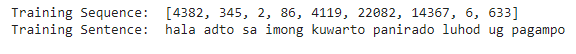

In [18]:
training_sequences=tokenizer.texts_to_sequences(X_train)     #=> training_sequence=np.asarray(tokenizer.texts_to_sequences(df['REVIEWS'].tolist())) #same as above
validation_sequences=tokenizer.texts_to_sequences(X_validation)
testing_sequences=tokenizer.texts_to_sequences(X_test)

#Show the new sequence and its equivalent sentence
print('Training Sequence: ',training_sequences[4])
print('Training Sentence: ',X_train[4])
#print('Testing Sequence',testing_sequences[101])
#print(str(tokenizer.texts_to_sequences(["fall gipadamgu"]))) #=> results to [1,1] an example of out of vocabulary

Training Sequence:  [1167, 2921, 2993, 3, 211, 94, 236, 17805, 2, 5, 1, 3, 391, 2, 17, 23039, 61, 2, 23040, 1179, 2, 148, 82]
Training Sentence:  malipayon ming naghunahuna nga tibuok adlaw silang maexpose sa mga cartoons nga makatabang sa ilang lessons sama sa sesame street sa among panahon


**4. Padding the sequence for a uniform Length**
<br>Make all of the sequences/sentences uniform in length through padding a sequence of 0s!<br>Example<br>
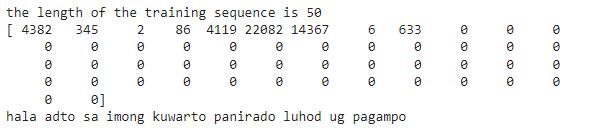

In [19]:
#from keras.preprocessing import sequence
from keras.preprocessing.sequence import pad_sequences

padded_training = pad_sequences(training_sequences,maxlen=sentence_length,padding= 'post',truncating='post')
#T=padded_training.shape[1]
#y = np.asarray(y_train)
#print('Length of the training sequence is',T)
#print('shape of label tensor',y.shape)
#print('Padded sentence',padded_training[101])

padded_validation = pad_sequences(validation_sequences,maxlen=sentence_length,padding= 'post',truncating='post')
#print('The length of the validation sequence is',padded_validation.shape[0])
#print('Padded sentence',padded_validation[101])

padded_testing = pad_sequences(testing_sequences,maxlen=sentence_length,padding= 'post',truncating='post')
#padded_testing = pad_sequences(testing_sequences,maxlen=T,padding= 'post',truncating='post')
#print('The length of the testing sequence is',padded_testing.shape[0])
#print('Padded sentence',padded_testing[101])

In [ ]:
#for seq in padded_testing: print(np.array(seq).shape)

**5. Load the (Pre-trained) Bisaya Word Embeddings** <br>
One of the most important technology and common denominator in all NLP use-cases is the mapping of words to a set of real numbers--vectors. The Word embeddings are vector representation capable of capturing the meaning of word in a document, semantic and syntactic similarity, relationship with other words. A way of converting the Bisaya words to numerical values is to use word2vec. Word2vec maps each word in a multidimensional space. It does by taking into account the context n which a word appears in the texts.As a result, words that are similar are close to each other in the multidimensional space. To relative embeddings of 300-dimension is learned from training using the Word2Vec skip-gram model. "

Load the Bisaya Skip-gram word embedding into memory as a dictionary of a
word to embedding vectors.

In [20]:
# load the whole "customized pre-trained word embeddings"  into embeddings_index. These vectors will be feed to our ML

from gensim.models import KeyedVectors

w2v_embeddings_index={}
w2v_model =KeyedVectors.load_word2vec_format('/content/drive/MyDrive/Colab Notebooks/data/bisayaEmbeddingModel300Dseries612.bin',binary=True)

for word in w2v_model.wv.index2word: #w2v_model.wv.vocab:
    w2v_embeddings_index[word] = w2v_model.wv.get_vector(word)
print('Loaded %s word vectors.'% len(w2v_embeddings_index))  #   xx40132 word vectors

#print(bisayaEmbeddingModel['mga'])
#print(w2v_embeddings_index["mga"])
#bisayaEmbeddingModel['ma'].shape  #300


Loaded 40132 word vectors.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  if __name__ == '__main__':


In [20]:
print(w2v_model["mga"])

[ 0.11140483  0.05717844 -0.06878012  0.01902441  0.02520449 -0.24690185
 -0.1639902   0.15144596 -0.01598958 -0.015915    0.09265285  0.04389953
 -0.0148679   0.12593846 -0.19714649  0.00500848  0.01113687 -0.00860906
  0.03591334 -0.13440922  0.21202384 -0.05243982  0.07297504  0.02103287
  0.11652139  0.08925578 -0.12316807  0.09295796 -0.13133982 -0.12678926
 -0.04036358  0.05782218  0.05219557  0.06270465 -0.09691479  0.04661522
  0.07289807 -0.0420926  -0.00704475 -0.06211439  0.03532087  0.01109914
  0.03656767 -0.03622013  0.06645709  0.03730164 -0.0225346  -0.03908349
 -0.12249976  0.03157796  0.01005841 -0.08492997 -0.01559604 -0.01499235
  0.2713211  -0.16947453  0.11676848  0.03108424 -0.11433632  0.09447723
 -0.19493547 -0.02598201  0.12646475  0.08652534  0.03563856  0.01603639
 -0.0689621  -0.04189521 -0.03365888 -0.11335458  0.09377597  0.02707062
 -0.0223607   0.01083941  0.00572775 -0.12622212 -0.02374641 -0.1941454
 -0.07796007 -0.06596062 -0.0131625   0.03557664  0.

**6. Transform the data into Embedding Matrix**
 <br>      Words in the dataset are looked up and assigned with the vectors. Create an embedding matrix for words in the training dataset.


In [21]:
#Convert data to embedding matrix to num_words x 300 shape

import numpy as np
embedding_dim = 300
MAX_NUM_WORDS = vocabularySize #max the number of vocabulary words
min_wordCount = 2
small_words=0
hits = 0
misses = 0
word_counts = tokenizer.word_index
small_counts=0
print ('Preparing the Embedding Matrix.......\n')
num_words = min(MAX_NUM_WORDS,len(wordIndex)+1)
embedding_matrix1 = np.zeros((num_words, embedding_dim)) #matrix of 51000 x 300
for word, i in wordIndex.items():
 # if word_counts[word] >= min_wordCount:
    if i< MAX_NUM_WORDS:
        #continue
     #if word in bisayaEmbeddingModel.vocab:   
        embedding_vector = w2v_embeddings_index.get(word) #bisayaEmbeddingModel[word] #    
        if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros. # This includes the representation for "padding" and "OOV"
             embedding_matrix1[i] = embedding_vector
             hits += 1
        else:
             #embedding_matrix1[i] = np.zeros((300,))
             misses += 1
  #else:
   #         small_words+=1
print('Total missed words are', misses, 'which is', "%0.2f" % (misses * 100 / len(wordIndex)),'% of total words')
#print('Words with '+str(min_wordCount)+' or less mentions', small_words, 'which is', "%0.2f" % (small_words * 100 / len(wordIndex)),'% of total words')

print("Embedding Matrix shape:", embedding_matrix1.shape)
print("Converted %d words (%d misses)" % (hits, misses))
#print(str(len(wordIndex)-small_words-misses) + ' words to proceed.')

Preparing the Embedding Matrix.......

Total missed words are 2508 which is 4.93 % of total words
Embedding Matrix shape: (30000, 300)
Converted 27491 words (2508 misses)


In [ ]:
#embedding_matrix1[word_counts['mga']]
#word_counts['abogasya']
#embedding_matrix1[2]

#**Building The Sentiment Model**

To best way to learn the fundamentals of a language is language modeling. Language model is the task to assign probabilities. These probabilites represent the likelihood the way we write or grammar or some sort of linguistic phenomnenon.

**Build the Sentiment Model**
 <br> This language model is Bidirectional LSTM. BiLSTM
is a sequence processing model that consists of two LSTMs: one taking the inputin a forward direction, and the other in a backward direction. BiLSTMs effectively increase the amount of information available to the network, therefore improving thecontext available to the algorithm. LSTM layer makes the decision to keep or throw awaydata by considering the current input, previous output, and previous memory.

**A. Model One** - Stacked BiLSTM

In [28]:
from keras.constraints import MaxNorm
from keras import regularizers

from keras.backend import dropout
from keras.models import Sequential
from keras.models import Model
from keras.layers import Embedding,Bidirectional, LSTM, Dense,Dropout

modelOne= Sequential(name="2-Stacked_BiLSTM_One")
embedding_Layer = (Embedding(input_dim=MAX_NUM_WORDS,output_dim=embedding_dim,weights=[embedding_matrix1],input_length=sentence_length,trainable=False, name="Embedding_Layer"))
modelOne.add(embedding_Layer)
modelOne.add(Dense(20, input_dim=300, kernel_initializer='he_uniform', activation='relu'))
modelOne.add(Dropout(0.1))
modelOne.add(Bidirectional(LSTM(64,activation='relu',return_sequences=True, recurrent_dropout=0.2, name='BiLSTM_Layer1'))) #
#modelOne.add(Bidirectional(LSTM(64,activation='relu',return_sequences=True, recurrent_dropout=0.2, name='BiLSTM_Layer1.5')))
#modelOne.add(Dropout(0.3))
#modelOne.add(Bidirectional(LSTM(32,activation='relu',return_sequences=False,recurrent_dropout=0.2,kernel_regularizer = regularizers.L2(0.02),kernel_initializer='he_uniform', kernel_constraint=MaxNorm(2),name='BiLSTM_Layer2')))
modelOne.add(Bidirectional(LSTM(64,activation='relu',return_sequences=False,recurrent_dropout=0.2,name='BiLSTM_Layer2')))
#modelOne.add(Dropout(0.3))
modelOne.add(Dense(1,activation='sigmoid',name='Output_Layer'))
modelOne.summary()

Model: "2-Stacked_BiLSTM_One"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Embedding_Layer (Embedding)  (None, 30, 300)          9000000   
                                                                 
 dense_1 (Dense)             (None, 30, 20)            6020      
                                                                 
 dropout_1 (Dropout)         (None, 30, 20)            0         
                                                                 
 bidirectional_2 (Bidirectio  (None, 30, 128)          43520     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 128)              98816     
 nal)                                                            
                                                                 
 Output_Layer (Dense)        (None, 1)        

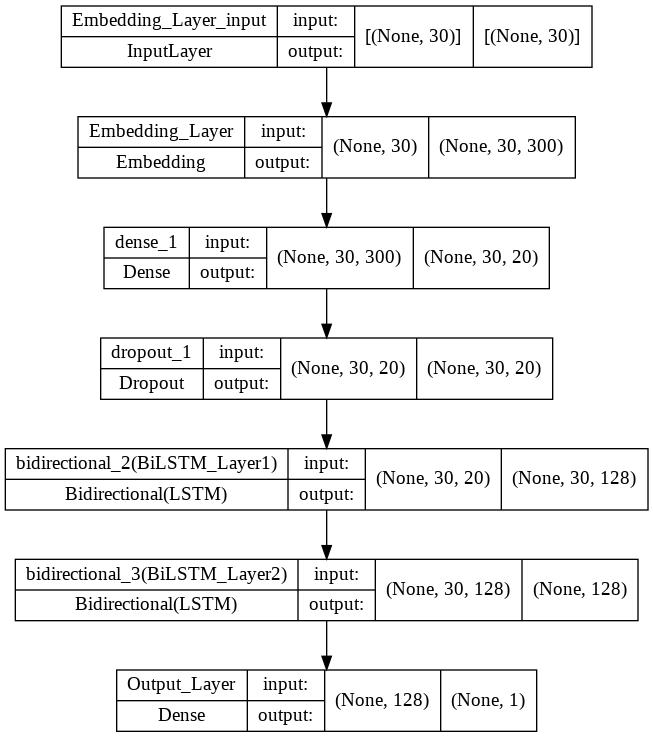

In [29]:
import tensorflow as tf
from tensorflow.keras.utils import plot_model
plot_model(modelOne,show_shapes=True, show_layer_names=True)

**Training the BiLSTM Model**


In [ ]:
import tensorflow as tf

LR_MAX = 0.00002
LR_MIN = 0.00001
LR_EXP_DECAY = 0.85

def lrfn(epoch):
    lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch) + LR_MIN
    return lr

    
lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint

es= EarlyStopping(monitor='val_loss',mode='min',verbose=1, patience=2)
mc=ModelCheckpoint('./model.h5',monitor='val_accuracy',mode='max',save_best_only=True)

In [30]:
#from keras.optimizers import adam_v2
#from keras.optimizers import gradient_descent_v2
 #opt=adam_v2.Adam(clipnorm=1, clipvalue=1)
#sgd=gradient_descent_v2.SGD(learning_rate=0.00001,decay=1e-6)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
modelOne.compile(optimizer=optimizer, loss='binary_crossentropy',metrics=['accuracy'])

In [31]:
import time

start =time.time()
history = modelOne.fit(padded_training, y_train, epochs=70, batch_size = 5000, validation_data=(padded_validation,y_validation),verbose=2) 
#history = modelOne.fit(padded_training, y_train, epochs=70, batch_size = 5000, validation_data=(padded_validation,y_validation),callbacks = [lr_callback],verbose=2) 
#history = modelOne.fit(padded_training, y_train, epochs=50, batch_size = 5000, validation_data=(padded_validation,y_validation),callbacks=[es,mc],verbose=2) 
#history = modelOne.fit(padded_training,y_train,batch_size=batch_size,epochs=100,steps_per_epoch=int(padded_training.shape[0]/batch_size), validation_data=(padded_validation,y_validation),verbose=1)

end= time.time()
print("Time elapsed in training:%.2f" %(end-start))

Epoch 1/70
9/9 - 71s - loss: 0.6933 - accuracy: 0.4876 - val_loss: 0.6930 - val_accuracy: 0.5019 - 71s/epoch - 8s/step
Epoch 2/70
9/9 - 54s - loss: 0.6930 - accuracy: 0.5079 - val_loss: 0.6928 - val_accuracy: 0.5284 - 54s/epoch - 6s/step
Epoch 3/70
9/9 - 55s - loss: 0.6928 - accuracy: 0.5302 - val_loss: 0.6925 - val_accuracy: 0.5501 - 55s/epoch - 6s/step
Epoch 4/70
9/9 - 55s - loss: 0.6925 - accuracy: 0.5449 - val_loss: 0.6920 - val_accuracy: 0.5647 - 55s/epoch - 6s/step
Epoch 5/70
9/9 - 66s - loss: 0.6920 - accuracy: 0.5481 - val_loss: 0.6914 - val_accuracy: 0.5685 - 66s/epoch - 7s/step
Epoch 6/70
9/9 - 58s - loss: 0.6914 - accuracy: 0.5584 - val_loss: 0.6905 - val_accuracy: 0.5779 - 58s/epoch - 6s/step
Epoch 7/70
9/9 - 58s - loss: 0.6904 - accuracy: 0.5631 - val_loss: 0.6890 - val_accuracy: 0.5898 - 58s/epoch - 6s/step
Epoch 8/70
9/9 - 59s - loss: 0.6887 - accuracy: 0.5792 - val_loss: 0.6867 - val_accuracy: 0.5980 - 59s/epoch - 7s/step
Epoch 9/70
9/9 - 56s - loss: 0.6863 - accuracy: 

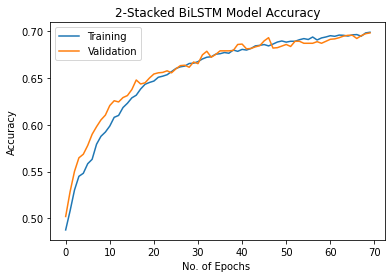

In [32]:
#Plot the learning Curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('2-Stacked BiLSTM Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. of Epochs ')
plt.legend(['Training','Validation'],loc='best')
plt.show()

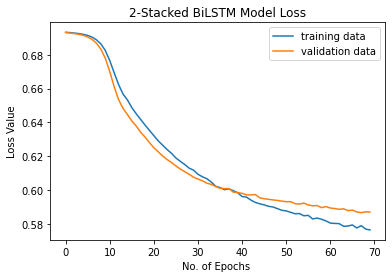

In [33]:
plt.plot(history.history['loss'],label='training data')
plt.plot(history.history['val_loss'],label='validation data')
plt.title('2-Stacked BiLSTM Model Loss')
plt.ylabel('Loss Value')
plt.xlabel('No. of Epochs ')
plt.legend(loc='upper right')
plt.show()

#**Evaluation**

              precision    recall  f1-score   support

           0       0.66      0.72      0.69      1148
           1       0.71      0.65      0.68      1195

    accuracy                           0.68      2343
   macro avg       0.69      0.68      0.68      2343
weighted avg       0.69      0.68      0.68      2343



[Text(0, 0.5, 'Positive'), Text(0, 1.5, 'Negative')]

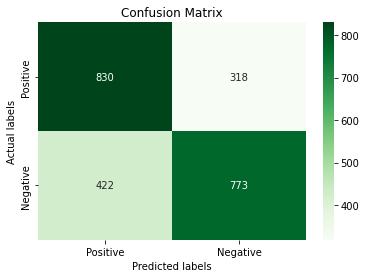

In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

ax=plt.subplot()
y_predict = modelOne.predict(padded_testing)
y_predict = np.where((y_predict) > 0.5,1,0)
print(classification_report(y_test,y_predict))

cm= confusion_matrix(y_test,y_predict)
sns.heatmap(cm, annot=True, fmt='d', ax= ax,cmap=plt.cm.Greens) #annotate cells

ax.set_xlabel('Predicted labels');ax.set_ylabel('Actual labels');
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(['Positive','Negative']);ax.yaxis.set_ticklabels(['Positive','Negative'])



#**Prediction**

In [36]:
#Generating prediction in all sample test data
data=pd.DataFrame(np.c_[y_predict,y_test], columns=["Predicted","Actual"])
data['Review'] = X_test
data['Predicted'] = y_predict
data['Predicted'] = np.where((data.Predicted >0.5),1,(data.Predicted).astype(int))
data['Predicted'] = np.where((data.Predicted < 0.5),0,(data.Predicted).astype(int))

data.head(5)

,Predicted,Actual,Review
0,1,0,ang mga tawo anha na lang molakaw sa karsada n...
1,0,0,kini ang hinungdan kun ngano nga ang tawo mahi...
2,1,1,hinuon dili sama ang sugbo sa metro manila dii...
3,1,1,bisag sa sabakan pa lamang dayag na ang pagkal...
4,0,1,lami kaayong paminawon mga higala nga itagbo k...


In [38]:
data.to_csv(r'/content/drive/MyDrive/Colab Notebooks/data/sentinotated.csv', index=False)

In [40]:
#Classifying real text
#from tensorflow.keras.preprocessing.text import Tokenizer

def predict_sentiment(sentence):
  sentence_lst=[]
  sentence_lst.append(sentence)
 # tokenizer = Tokenizer()
  sentence_sequence=tokenizer.texts_to_sequences(sentence_lst)
  padded_sentence = pad_sequences(sentence_sequence,maxlen=sentence_length,padding='post')
  probability=modelOne.predict(padded_sentence)[0][0]
  if probability >0.5:
    print(f'POSITIVE {np.round(probability*100,2)}%')
  else:
    print(f'NEGATIVE {100-(np.round(probability *100,2))}%')
   


In [42]:
predict_sentiment(str(input("Enter the sentence: ")))

Enter the sentence: basi sa mga impormasyon nga gipanghisgutan sa pipila ka brodkaster maayo baya ang negusyo niining zafra
POSITIVE 57.68%


**================================================== END ===============================================**

In [39]:
#keras.evaluate() is for evaluating your trained model. Its output is accuracy or loss, not prediction to your input data.
#keras.predict() actually predicts, and its output is target value, predicted from your input data

from sklearn.metrics import accuracy_score

#Evaluation from each split
print('Train split')
loss, accuracy = modelOne.evaluate(padded_training, y_train, verbose=0)
#accuracy = accuracy_score(y_test, y_predict)
print('Accuracy: %f' % (accuracy*100))
print('Loss : %f' % (loss*100))
print('------------------------')


print('Validation split')
loss, accuracy = modelOne.evaluate(padded_validation, y_validation, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss : %f' % (loss*100))
print('------------------------')

print('Test split:')
loss, accuracy = modelOne.evaluate(padded_testing, y_test, verbose=0)
print('Accuracy: %f' % (accuracy*100))
print('Loss : %f' % (loss*100))

Train split
Accuracy: 70.345777
Loss : 57.022387
------------------------
Validation split
Accuracy: 69.825011
Loss : 58.708626
------------------------
Test split:
Accuracy: 68.416560
Loss : 59.074479


In [ ]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,precision_score
print("MOdel Accuracy", accuracy_score(y_test, y_predict))
print("Model f1 score", f1_score(y_test, y_predict))
print("MOdel Recall", recall_score(y_test, y_predict))
print("Model Precision",precision_score(y_test, y_predict))


#RNNsemicolon


MOdel Accuracy 0.7119078104993598
Model f1 score 0.6960828455650607
MOdel Recall 0.6377887788778878
Model Precision 0.7661050545094152


In [ ]:
# histogram of predicted probabilities
%matplotlib inline
import matplotlib.pyplot as plt

# allow plots to appear in the notebook
plt.hist(y_pred, bins=8)
plt.xlim(0, 1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of All Positive Texts')
plt.ylabel('Frequency')

NameError: ignored